In [1]:
import pandas as pd 
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm 
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, LineString

/opt/anaconda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"

#we are bringing in the data with demographic information and cluster ids 
#hence, merged
#MVP path merged = pd.read_csv("/shared/3/projects/benlitterer/localNews/data/interim/SingleNE_85_clustered.tsv", sep="\t")
merged = pd.read_csv(IN_PATH, sep="\t")
merged = merged.dropna(subset=["clustNum"]) 

#first make sure we have the date of an outlet correctly specified 
merged["date"] = pd.to_datetime(merged["date"])

<ipython-input-2-60fe77151f20>:6: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  merged = pd.read_csv(IN_PATH, sep="\t")


In [3]:
#variables that we will merge into graph after creating it
#in networkx
demVars = ["clustNum", "source"]

#get pairwise information
#by sorting in this way then calling drop_duplicates, we only consider the first mention of a story by 
#an outlet. Simplifies the analysis but introduces an assumption 
#example: merged.head(300)[["clustNum", "source", "date"]].sort_values(["clustNum", "source", "date"]).head(20)
pairwise = merged.sort_values(["clustNum", "source", "date"]).drop_duplicates(subset=["clustNum", "source"])

#group into clusters
pairwise = pairwise.loc[pairwise["national"] == False, ["key"] + demVars]
pairwise = pairwise.groupby(by="clustNum").agg(list)
pairwise["clustSize"] = pairwise["source"].apply(len)

#NOTE: we remove very large clusters? because they slow down getting pairwise information 
pairwise = pairwise[pairwise["clustSize"] < 2000].drop(columns=["clustSize"])

#get pairs of sources, with no duplicate pairs 
def getPairwise(inList):
    outList = []
    for i in range(0, len(inList)-1): 
        for j in range(i + 1, len(inList)): 
            outList.append((inList[i], inList[j]))
    return outList

#applied across an entire series 
def getPairwiseSeries(inSeries): 
    return inSeries.apply(getPairwise)

pairwise["source"] = pairwise["source"].apply(getPairwise)
pairwise = pairwise.explode(["source"])
#pairwise[["date1", "date2"]] = pd.DataFrame(pairwise["date"].tolist(), index=pairwise.index)

In [4]:
pairwise = pairwise.dropna()
pairwise[["source1", "source2"]] = pd.DataFrame(pairwise["source"].tolist(), index=pairwise.index)
pairwise[["source1", "source2"]] = np.sort(pairwise[["source1", "source2"]], axis=1)

In [5]:
def getEdgeWeights(inDf):
    totalEdges = len(inDf)
    grouped = inDf
    grouped["edgeCount"] = 1
    
    #get the percent of edges that are between each node
    grouped = grouped[["source1", "source2", "edgeCount"]].groupby(by=["source1", "source2"]).agg(lambda x: (sum(x) / totalEdges) * 100)
    
    return grouped.to_dict(orient="index")

In [6]:
#now, create our config model 
#create graph from pandas dataframe. Allow parallel edges!
outletGraph = nx.from_pandas_edgelist(pairwise[["source1", "source2"]], source="source1", target="source2", create_using=nx.MultiGraph)

In [7]:
nullWeights = {}

#config model runs 
for i in tqdm(range(10)):

    #create config model 
    #the config model creates a graph with the number of in and out degrees that we see in our graph 
    #the nodes are random though, so we are assuming that there is no relationship between 
    #any node characteristics and their degrees 
    degree = [tup[1] for tup in outletGraph.degree()]
    configModel = nx.configuration_model(degree)

    #NOTE: we have a different number of edges now so we will need to scale by that! 
    #configModel.remove_edges_from(nx.selfloop_edges(configModel))

    #set the config model to have the same nodes and attributes as the original model 
    nodeMapping = dict(zip(list(configModel.nodes()), list(outletGraph.nodes())))
    configModel = nx.relabel_nodes(configModel, nodeMapping)
    
    #get the edges from the graph
    edgeDf = nx.to_pandas_edgelist(configModel, source="source1", target="source2")
    edgeDf[["source1", "source2"]] = np.sort(edgeDf[["source1", "source2"]], axis=1)
    
    edgeSums = getEdgeWeights(edgeDf)
    
    #add these edge weights to our distribution of 
    #edge weights 
    for k in edgeSums.keys(): 
        currWeight = edgeSums[k]["edgeCount"]
        if k not in nullWeights:
            nullWeights[k] = [currWeight]
        else: 
            nullWeights[k].append(currWeight)
        

100%|██████████| 10/10 [01:48<00:00, 10.81s/it]


In [8]:
#NOTE: we can sanity check our config model by 
#making sure that the degrees are the same between these
#NOTE: bias due to removing self-edges
#configModel.degree
#outletGraph.degree

In [9]:
#get a count of edgeWeights in our current graph 
observedWeights = getEdgeWeights(pairwise)

In [10]:
def getZScore(observed, inList): 
    if len(inList) == 0: 
        return 0
    if np.std(inList) == 0: 
        return 0
    return (observed - np.mean(inList)) / np.std(inList)

standardWeights = {}
for k in observedWeights.keys(): 
    observed = observedWeights[k]["edgeCount"]
    if k in nullWeights: 
        nullVals = nullWeights[k]
        zScore = getZScore(observed, nullVals)
        standardWeights[k] = zScore
    else: 
        #very very rare that this happens 
        standardWeights[k] = 0
    

In [11]:
#perhaps we can set these to the highest zscore later? 
counter = 0 
for k, v in standardWeights.items(): 
    if v == 3000: 
        counter += 1
counter / len(standardWeights.keys())

0.0

In [12]:
#put weights into a dataframe for easier manipulation
sWeightsDf = pd.DataFrame.from_dict(standardWeights, orient="index", columns=["zScore"]).reset_index()
sWeightsDf[["source1", "source2"]] = pd.DataFrame(sWeightsDf["index"].tolist(), index=sWeightsDf.index)

(-10.0, 10.0)

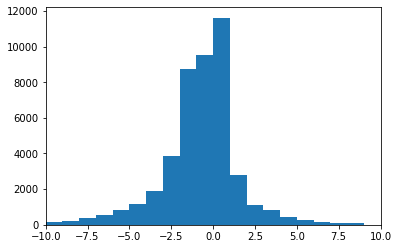

In [13]:
plt.hist(sWeightsDf["zScore"], bins=np.arange(-10, 10, 1))
plt.xlim(-10, 10)

In [14]:
#now merge in our lat/lon information 
#TODO: extend to have everything we're interested in 
#we use this to merge demographic variables onto our configuration model network 
outletDf = merged[["source", "lat", "lon"]].drop_duplicates(["source"]).drop_duplicates()
temp = pd.merge(sWeightsDf, outletDf.rename(columns={"source":"source1"}), on="source1")
temp = pd.merge(temp, outletDf.rename(columns={"source":"source2"}), on="source2")

sWeightsDf = temp

In [15]:
sWeightsDf["coord_x"] = list(zip(sWeightsDf["lon_x"], sWeightsDf["lat_x"]))
sWeightsDf["coord_y"] = list(zip(sWeightsDf["lon_y"], sWeightsDf["lat_y"]))
sWeightsDf["geoPair"] = sWeightsDf.apply(lambda x: [x["coord_x"], x["coord_y"]], axis=1)


In [16]:
states = gpd.read_file("/home/blitt/reference/geospatial/shapeFiles/cb_2018_us_state_5m")

In [32]:

import plotly
plotly.offline.init_notebook_mode(connected=True)

(array([259., 224., 271., 149.,  48.,  25.,  13.,   5.,   4.,   2.]),
 array([0.3451874 , 0.41066866, 0.47614992, 0.54163118, 0.60711244,
        0.6725937 , 0.73807496, 0.80355622, 0.86903748, 0.93451874,
        1.        ]),
 <BarContainer object of 10 artists>)

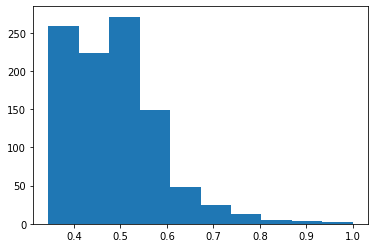

In [57]:
opacityList = np.log(topEdges["zScore"])  / np.log(max(topEdges["zScore"]))

plt.hist(opacityList)

(20.0, 50.0)

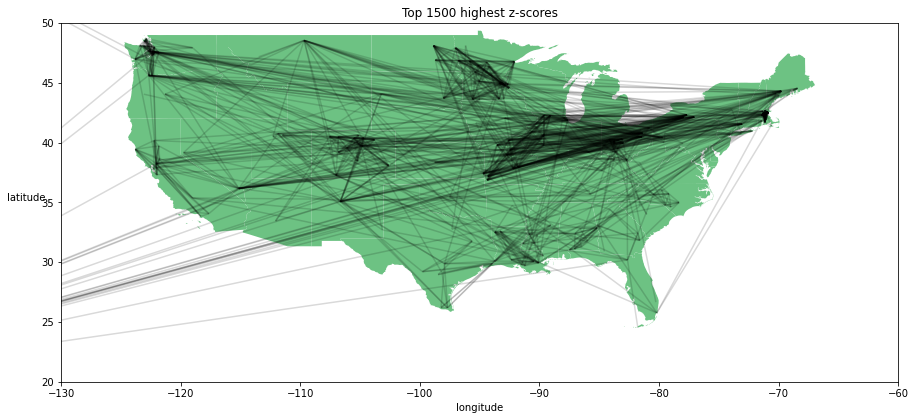

In [81]:
lines = [LineString(item) for item in sWeightsDf["geoPair"]]
lineGdf = gpd.GeoDataFrame(sWeightsDf, geometry=lines)

NUM_EDGES = 1500
topEdges = lineGdf[lineGdf["zScore"] < 3000]
topEdges = lineGdf.sort_values("zScore", ascending=False).head(NUM_EDGES)

topEdges.plot(ax=states.plot(figsize=(15, 10), color="#6dc283"), color="black", alpha=.15)


#need to think about scaling for the number of articles produced? 
#obviously small outlets aren't going to have many connections 
plt.title("Top " + str(NUM_EDGES) + " highest z-scores")
plt.xlabel("longitude")
plt.ylabel("latitude", rotation=0, labelpad=15)
plt.xlim([-130, -60])
plt.ylim([20, 50])

In [ ]:
lines = [LineString(item) for item in sWeightsDf["geoPair"]]
lineGdf = gpd.GeoDataFrame(sWeightsDf, geometry=lines)

NUM_EDGES = 1000
topEdges = lineGdf[lineGdf["zScore"] < 3000]
topEdges = lineGdf.sort_values("zScore", ascending=False).head(NUM_EDGES)

myPlot = topEdges.explore(ax=states.plot(figsize=(15, 10), color="#6dc283"), color="black", alpha=.15)


#need to think about scaling for the number of articles produced? 
#obviously small outlets aren't going to have many connections 
plt.title("Top " + str(NUM_EDGES) + " highest z-scores")
plt.xlabel("longitude")
plt.ylabel("latitude", rotation=0, labelpad=15)
plt.xlim([-165, -65])
plt.ylim([15, 50])

In [ ]:
myPlot = topEdges.explore(ax=states.plot(figsize=(15, 10), color="#6dc283"), color="black", alpha=.15)

In [79]:
lines = [LineString(item) for item in sWeightsDf["geoPair"]]
lineGdf = gpd.GeoDataFrame(sWeightsDf, geometry=lines)

NUM_EDGES = 1500
topEdges = lineGdf[lineGdf["zScore"] < 3000]
topEdges = lineGdf.sort_values("zScore", ascending=False).head(NUM_EDGES)

HTML_PATH = "/home/blitt/projects/localNews/notebooks/similarityAnalysis/plotly/testPlot.html"
outletDf = merged[["source", "city", "lat", "lon", "state"]].drop_duplicates(["source"]).drop_duplicates()
outletDf["displayText"] = outletDf["source"] + " - " + outletDf["city"] + ", " + outletDf["state"]

import plotly.graph_objects as go
import pandas as pd

df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df_airports.head()

df_flight_paths = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_aa_flight_paths.csv')
df_flight_paths.head()

fig = go.Figure()

flight_paths = []
for i, row in topEdges.iterrows():
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [row["lon_x"], row["lon_y"]],
            lat = [row["lat_x"], row["lat_y"]],
            mode = 'lines',
            hoverinfo = "none", 
            line = dict(width = 1,color = 'black'),
            opacity = np.log(row["zScore"]) / np.log(max(topEdges["zScore"]))
        )
    )

    
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = outletDf['lon'],
    lat = outletDf['lat'],
    hoverinfo = 'text',
    text = outletDf['displayText'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))


    
fig.update_layout(
    title_text = '',
    showlegend = False,
    geo = dict(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'grey',
        showsubunits = True
    ),
)

fig.write_html(HTML_PATH)